In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../estudo_inicial/bases_de_dados/base_de_dados_formatada_rim.csv")
df = df[df.delta_t>0]
df = df.drop(columns=['regiao','data_da_inscricao','data_do_evento'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47069 entries, 0 to 47597
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uf               47069 non-null  object 
 1   sexo             47069 non-null  object 
 2   grupo_sanguineo  47069 non-null  object 
 3   cor              47069 non-null  object 
 4   uf_origem        47069 non-null  object 
 5   tipo_de_doador   37902 non-null  object 
 6   idade            47069 non-null  float64
 7   obito_bin        47069 non-null  int64  
 8   transplante_bin  47069 non-null  int64  
 9   delta_t          47069 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 4.0+ MB


In [3]:
df_bin = df.fillna(0)

bin_cols = [
    "uf",
    "tipo_de_doador",
    "uf_origem",
    "sexo",
    "grupo_sanguineo",
    "cor",
]

for col in bin_cols:

    
    # converting to binary data
    df_one = pd.get_dummies(
        df[col],
    )

    # Use the .replace() method to map True/False to 1/0


    df_one[df_one==True] = 1
    df_one[df_one==False] = 0

    # Recolocando NaN
    df_one.loc[df[col].isnull()] = None

    # Renomeando colunas
    new_columns = [
        col + "_" + category.strip().replace(" ", "_") for category in df_one.columns
    ]

    df_one.columns = new_columns

    df_aux = pd.concat([df_bin, df_one],axis=1)

    df_aux = df_aux.drop(columns=[col])

    df_bin = df_aux

df_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47069 entries, 0 to 47597
Data columns (total 68 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   idade                           47069 non-null  float64
 1   obito_bin                       47069 non-null  int64  
 2   transplante_bin                 47069 non-null  int64  
 3   delta_t                         47069 non-null  float64
 4   uf_AC                           47069 non-null  object 
 5   uf_AL                           47069 non-null  object 
 6   uf_AM                           47069 non-null  object 
 7   uf_BA                           47069 non-null  object 
 8   uf_CE                           47069 non-null  object 
 9   uf_DF                           47069 non-null  object 
 10  uf_ES                           47069 non-null  object 
 11  uf_GO                           47069 non-null  object 
 12  uf_MA                           47069

# Predição de óbito

In [72]:
df_obito = df_bin.drop(
    columns=["tipo_de_doador_Doador_Falecido", "tipo_de_doador_Doador_Vivo"]
)

In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_obito = pd.DataFrame(scaler.fit_transform(df_obito), columns=df_obito.columns)

<Axes: >

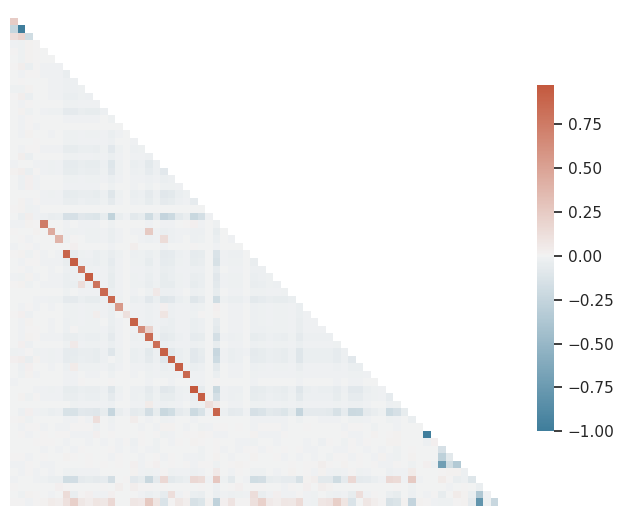

In [75]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_obito.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    # linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=False, yticklabels=False
    
)

In [77]:
corr_abs = ((corr.fillna(0)) ** 2) ** 0.5
pd.DataFrame(
    {
        "Atributo": corr_abs.obito_bin.sort_values(ascending=False).index,
        "Correlação": corr_abs.obito_bin.sort_values(ascending=False).values,
    }
).head(12)

,Atributo,Correlação
0,obito_bin,1.000000
1,transplante_bin,1.000000
2,idade,0.239879
3,delta_t,0.184446
4,uf_origem_RJ,0.038420
5,uf_PI,0.031489
6,uf_BA,0.031395
7,uf_SP,0.030764
8,uf_GO,0.029050
9,uf_RJ,0.029025


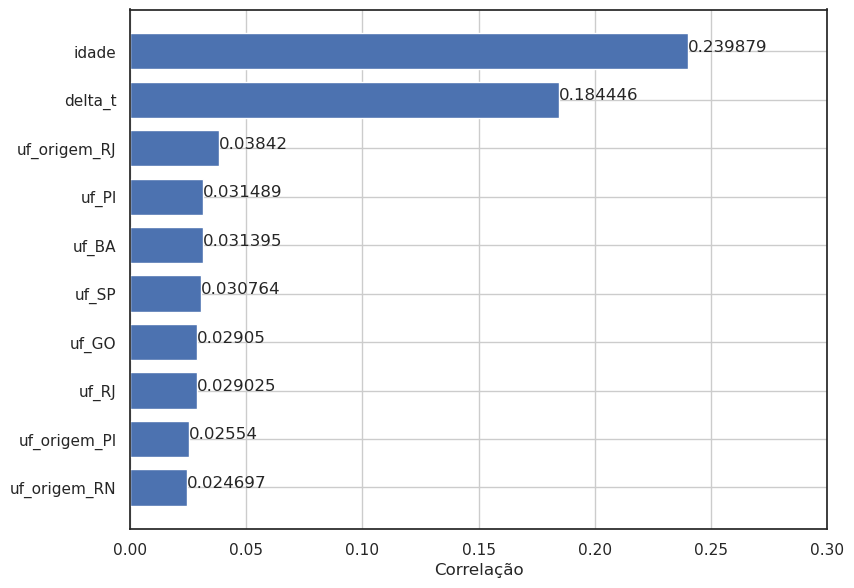

In [78]:
import matplotlib.pyplot as plt
import numpy as np

k = 0.75

fig = plt.figure(figsize=[k * 12, k * 9])

# Example data
people = (
    "idade",
    "delta_t",
    "uf_origem_RJ",
    "uf_PI",
    "uf_BA",
    "uf_SP",
    "uf_GO",
    "uf_RJ",
    "uf_origem_PI",
    "uf_origem_RN",
)
y_pos = np.arange(len(people))
performance = [
    0.239879,
    0.184446,
    0.038420,
    0.031489,
    0.031395,
    0.030764,
    0.029050,
    0.029025,
    0.025540,
    0.024697,
]

ax = fig.add_subplot(1, 1, 1)

width = 0.75

ax.barh(
    y_pos,
    performance,
    width,
    align="center",
)

for i, v in enumerate(performance):
    ax.text(v, i, str(v), fontsize=12)

ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Correlação")
ax.set_xlim(0, 0.3)
ax.grid()

plt.show()

Total explained variance ratio: 0.43525133525773


Text(0.5, 0.92, 'PCA')

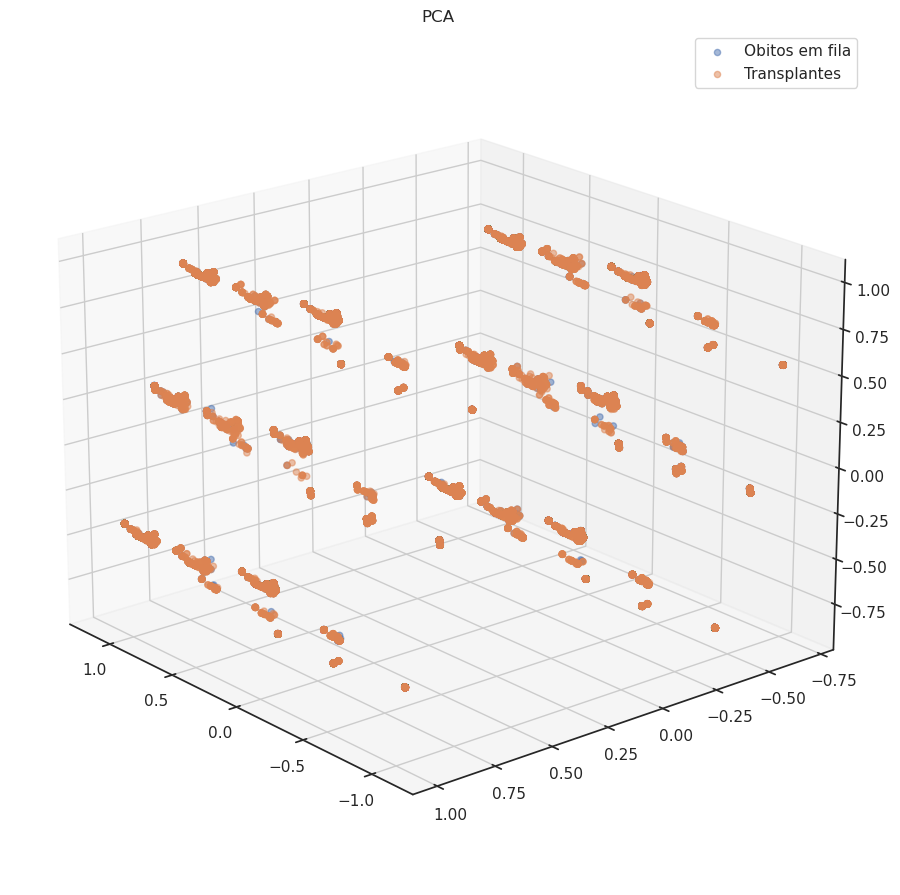

In [79]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(9, 9))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=20, azim=140)
ax.set_position([0, 0, 0.95, 1])

X = df_obito.drop(columns=["obito_bin", "transplante_bin"])

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

print("Total explained variance ratio: %s" % str(sum(pca.explained_variance_ratio_)))

target_names = ["Óbito em fila", "Transplante"]
lw = 1


ax.scatter(
    X_r[df_obito["transplante_bin"] == 0, 0],
    X_r[df_obito["transplante_bin"] == 0, 1],
    X_r[df_obito["transplante_bin"] == 0, 2],
    alpha=0.5,
    lw=lw,
    label="Obitos em fila",
)

ax.scatter(
    X_r[df_obito["transplante_bin"] == 1, 0],
    X_r[df_obito["transplante_bin"] == 1, 1],
    X_r[df_obito["transplante_bin"] == 1, 2],
    alpha=0.5,
    lw=lw,
    label="Transplantes",
)


ax.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")

# Previsão de tempo para tranplante

In [30]:
df_prev = df_bin[df_bin.transplante_bin == 1]
df_prev = df_prev.drop(columns=['obito_bin','transplante_bin'])
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37863 entries, 0 to 38330
Data columns (total 66 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   idade                           37863 non-null  float64
 1   delta_t                         37863 non-null  float64
 2   uf_AC                           37863 non-null  object 
 3   uf_AL                           37863 non-null  object 
 4   uf_AM                           37863 non-null  object 
 5   uf_BA                           37863 non-null  object 
 6   uf_CE                           37863 non-null  object 
 7   uf_DF                           37863 non-null  object 
 8   uf_ES                           37863 non-null  object 
 9   uf_GO                           37863 non-null  object 
 10  uf_MA                           37863 non-null  object 
 11  uf_MG                           37863 non-null  object 
 12  uf_MS                           37863

In [31]:
df_prev = df_prev.dropna(
    subset=["tipo_de_doador_Doador_Falecido", "tipo_de_doador_Doador_Vivo"], how="any"
)
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30317 entries, 0 to 38330
Data columns (total 66 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   idade                           30317 non-null  float64
 1   delta_t                         30317 non-null  float64
 2   uf_AC                           30317 non-null  object 
 3   uf_AL                           30317 non-null  object 
 4   uf_AM                           30317 non-null  object 
 5   uf_BA                           30317 non-null  object 
 6   uf_CE                           30317 non-null  object 
 7   uf_DF                           30317 non-null  object 
 8   uf_ES                           30317 non-null  object 
 9   uf_GO                           30317 non-null  object 
 10  uf_MA                           30317 non-null  object 
 11  uf_MG                           30317 non-null  object 
 12  uf_MS                           30317

In [80]:
df_prev = pd.DataFrame(scaler.fit_transform(df_prev), columns=df_prev.columns)

<Axes: >

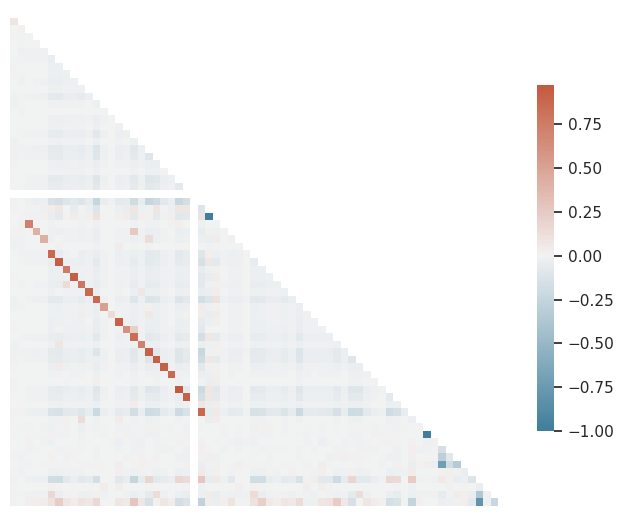

In [81]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = df_prev.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    # linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=False, yticklabels=False
    
)

In [82]:
corr_abs = ((corr.fillna(0)) ** 2) ** 0.5
pd.DataFrame(
    {
        "Atributo": corr_abs.delta_t.sort_values(ascending=False).index,
        "Correlação": corr_abs.delta_t.sort_values(ascending=False).values,
    }
).head(11)

,Atributo,Correlação
0,delta_t,1.000000
1,idade,0.080597
2,uf_GO,0.014861
3,uf_AC,0.013400
4,uf_BA,0.013391
5,uf_origem_AC,0.010872
6,uf_PR,0.009880
7,uf_AL,0.009313
8,uf_origem_GO,0.008551
9,uf_origem_PR,0.008383


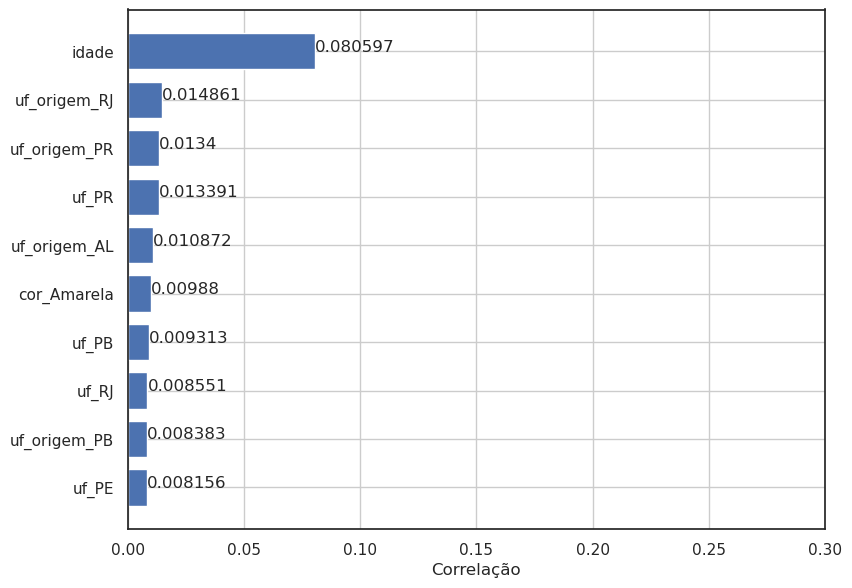

In [83]:
import matplotlib.pyplot as plt
import numpy as np

k = 0.75

fig = plt.figure(figsize=[k * 12, k * 9])


# Example data
people = (
    "idade",
    "uf_origem_RJ",
    "uf_origem_PR",
    "uf_PR",
    "uf_origem_AL",
    "cor_Amarela",
    "uf_PB",
    "uf_RJ",
    "uf_origem_PB",
    "uf_PE",
)
y_pos = np.arange(len(people))
performance = [
    0.080597,
    0.014861,
    0.013400,
    0.013391,
    0.010872,
    0.009880,
    0.009313,
    0.008551,
    0.008383,
    0.008156,
]

ax = fig.add_subplot(1, 1, 1)

width = 0.75

ax.barh(
    y_pos,
    performance,
    width,
    align="center",
)

for i, v in enumerate(performance):
    ax.text(v, i, str(v), fontsize=12)

ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Correlação")
ax.set_xlim(0, 0.3)
ax.grid()

plt.show()

Total explained variance ratio: 0.1547137158852876


Text(0.5, 1.0, 'PCA')

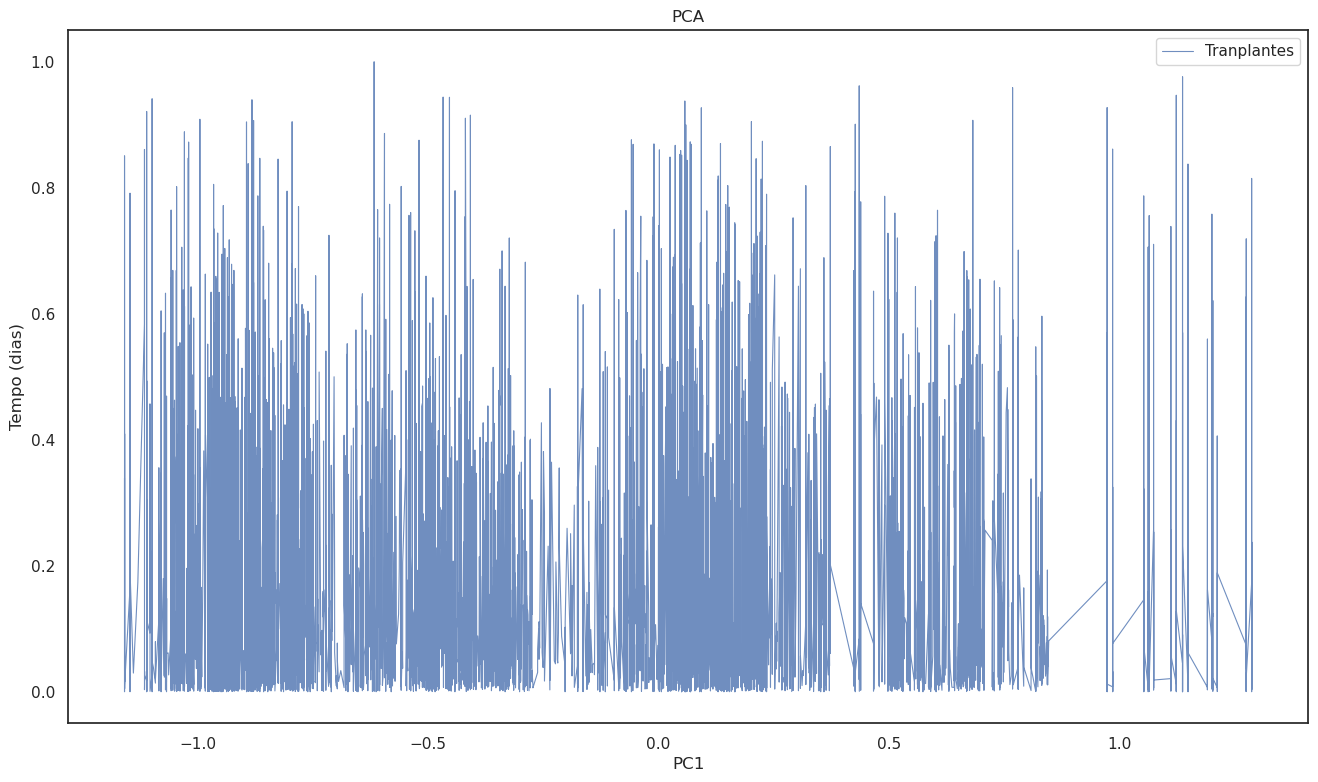

In [92]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(16, 9))

ax = fig.add_subplot(111)

X = df_prev.drop(columns=['delta_t'])
y = df_prev.delta_t.values

pca = PCA(n_components=1)
X_r = pca.fit(X).transform(X)

p = X_r.argsort(axis=0)

print(
    "Total explained variance ratio: %s"
    % str(sum(pca.explained_variance_ratio_))
)

target_names = ["Óbito em fila", "Transplante"]
lw = 1

ax.plot(
    X_r[p].reshape(30317,1),
    y[p],
    alpha=0.8,
    label="Tranplantes",
    linewidth=0.8
)

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_xlabel("PC1")
ax.set_ylabel("Tempo (dias)")
plt.title("PCA")

In [115]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = MLPRegressor(
    hidden_layer_sizes=(120, 120),
    max_iter=50,
    early_stopping=True,
).fit(X_train, y_train)

prev = regr.predict(X_test)
print(regr.score(X_test, y_test))

rmse = np.mean(((y_test-prev)**2)**0.5)

print(rmse)

-0.017816192716842538
0.11022118802403118


Text(0.5, 1.0, 'Curva de aprendizado')

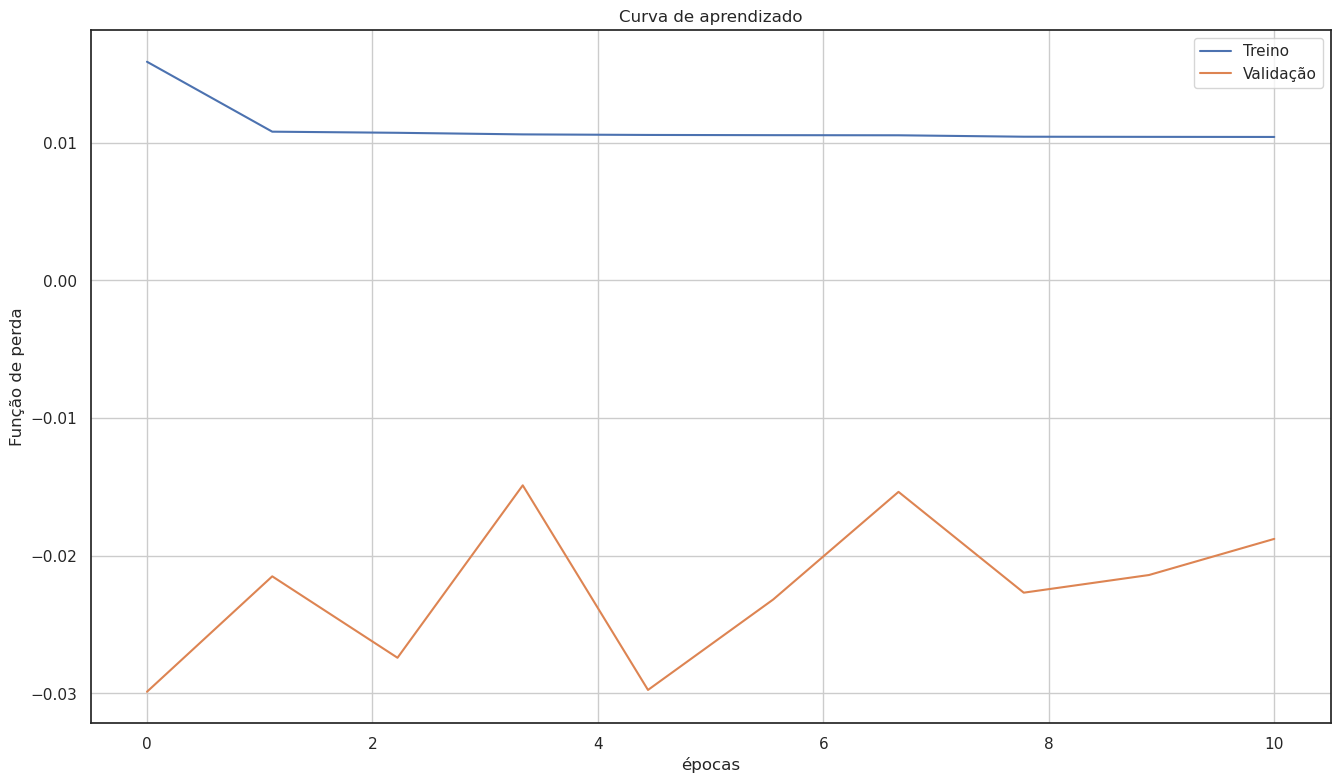

In [105]:
fig = plt.figure(1, figsize=(16, 9))

ax = fig.add_subplot(111)

ax.plot(
    np.linspace(0,len(regr.loss_curve_),num=len(regr.loss_curve_)),
    regr.loss_curve_,
    label="Treino",
)

plt.plot(
    np.linspace(0,len(regr.validation_scores_),num=len(regr.validation_scores_)),
    regr.validation_scores_,
    label="Validação",
)

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_xlabel("épocas")
ax.set_ylabel("Função de perda")
ax.grid()
plt.title("Curva de aprendizado")

Text(0.5, 1.0, 'PCA')

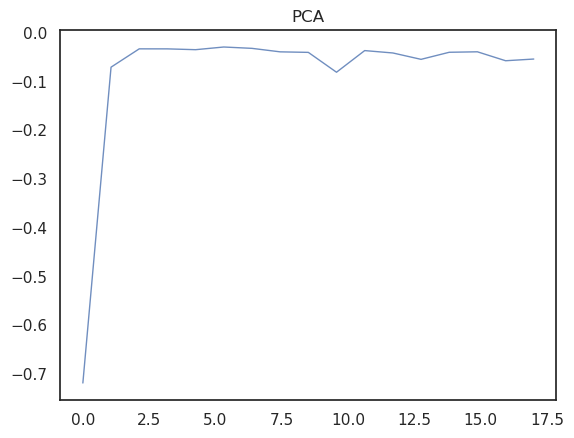

In [93]:
plt.plot(
    np.linspace(0,len(regr.validation_scores_),num=len(regr.validation_scores_)),
    regr.validation_scores_,
    alpha=0.8,
    lw=lw,
    label="Validação",
)

plt.title("PCA")